In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 14.24 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=b45a7d0c37e431c110fe6d6940cd7f3e0dc9de438ffa7d88135442f4a9db0f89
  Stored in directory: /tmp/pip-ephem-wheel-cache-26tdfioi/wheels/55/59/29/0fb1c635652157734

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


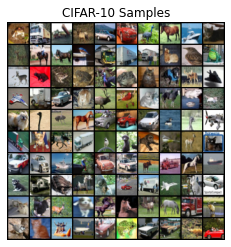

In [4]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [17]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [6]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4)\
            .reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super(Upsample_Conv2d, self).__init__()
        self.dts = DepthToSpace(block_size=2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        return self.conv(self.dts(torch.cat([x, x, x, x], dim=1)))


class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super(Downsample_Conv2d, self).__init__()
        self.std = SpaceToDepth(2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        return self.conv(sum(self.std(x).chunk(4, dim=1)) / 4.0)


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResnetBlockUp, self).__init__()
        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1),
        )   
        self.shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        
    def forward(self, x):
        return self.residual(x) + self.shortcut(x)


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResnetBlockDown, self).__init__()
        self.residual = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.ReLU(),
            Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1),
        )
        self.shortcut = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        return self.residual(x) + self.shortcut(x)


class Generator(nn.Module):
    def __init__(self, n_filters=128):
        super(Generator, self).__init__()
        self.dist = torch.distributions.Normal(0, 1)
        self.linear = nn.Linear(128, 4 * 4 * 256)
        self.layers = nn.Sequential(
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.layers(self.linear(z).reshape(-1, 256, 4, 4))

    def sample(self, n_samples=1024):
        return self.forward(self.dist.sample([n_samples, 128]).to(device))


class Printer(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x


class Discriminator(nn.Module):
    def __init__(self, n_filters=128):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, n_filters, kernel_size=(3, 3), padding=1),
            nn.Tanh(),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=256),
            nn.ReLU(),
        ).float()
        self.linear = nn.Linear(4 * 4 * 256, 1)

    def forward(self, z):
        z = self.layers(z).reshape(z.shape[0], -1)
        return self.linear(z)


class GAN:
    def __init__(self, n_iter=30000, batch_size=256):
        self.generator = Generator().float().to(device)
        self.discriminator = Discriminator().float().to(device)
        self.n_iter = n_iter
        self.batch_size = batch_size

    def sample(self, n_samples=1000):
        return (self.generator.sample(n_samples).cpu().detach().numpy().transpose(0, 2, 3, 1) + 1) / 2

    def discriminator_loss(self, batch, generated_batch):
        alpha = torch.rand(batch.shape[0], 1, 1, 1).to(device)
        #print(batch.shape, generated_batch.shape)
        input = alpha * batch + (1 - alpha) * generated_batch
        #print(input.shape)
        output = self.discriminator(input)
        grad = torch.autograd.grad(
            outputs=output, 
            inputs=input,
            grad_outputs=torch.ones_like(output),
            create_graph=True,
            retain_graph=True)[0]
        penalty = ((torch.sqrt(torch.sum(grad.reshape(batch.shape[0], -1) ** 2, dim=1)) - 1) ** 2).mean()
        return self.discriminator(generated_batch).mean() - self.discriminator(batch).mean() + 10 * penalty

    def fit(self, data):
        data = 2 * data - 1
        dataloader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        disc_opt = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0, 0.9))
        gen_opt = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0, 0.9))

        i = 0
        loss_list = []
        with tqdm(total=self.n_iter) as pbar:
            while True:
                for batch in dataloader:
                    batch = batch.float().to(device)
                    if i == self.n_iter:
                        return loss_list

                    disc_opt.zero_grad()
                    generated_batch = self.generator.sample(batch.shape[0])
                    loss = self.discriminator_loss(batch, generated_batch)
                    loss.backward()
                    disc_opt.step()

                    loss_list.append(loss.item())

                    if i % 5 == 0:
                        gen_opt.zero_grad()
                        generated_batch = self.generator.sample(self.batch_size)
                        loss = - self.discriminator(generated_batch).mean()
                        loss.backward()
                        gen_opt.step()

                    i += 1
                    pbar.update(1)


In [8]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    gan = GAN(n_iter=1000)
    loss = gan.fit(train_data)
    samples = gan.sample(1000)
    return np.array(loss), samples

## Results

25000 итераций слишком много для колаба.

Files already downloaded and verified


100%|██████████| 1000/1000 [1:09:16<00:00,  4.16s/it]


..........Inception score: 3.428469


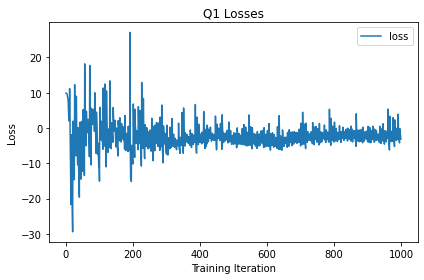

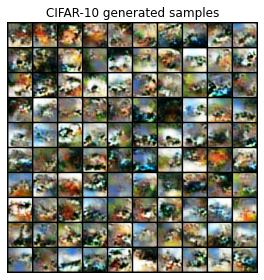

In [9]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



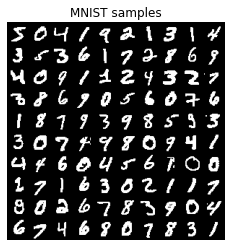

In [4]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [65]:
class Generator(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=1024, x_dim=28):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.model = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim * x_dim),
            nn.Tanh(),
        )
        self.dist = torch.distributions.Normal(0, 1)

    def forward(self, z):
        return self.model(z).reshape(z.shape[0], 1, self.x_dim, self.x_dim)

    def sample(self, n_samples):
        z_samples = self.dist.sample([n_samples, self.z_dim]).to(device)
        return z_samples, self.forward(z_samples)


class Encoder(nn.Module):
    def __init__(self, x_dim=28, hidden_dim=1024, z_dim=50):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(x_dim * x_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, z_dim),
        )

    def forward(self, x):
        return self.model(x.reshape(x.shape[0], -1))


class Discriminator(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=1024, x_dim=28):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim + x_dim * x_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, z, x):
        return self.model(torch.cat((z, x.reshape(x.shape[0], -1)), dim=1))


class BiGAN:
    def __init__(self, n_iter=30000, batch_size=128):
        self.generator = Generator().float().to(device)
        self.discriminator = Discriminator().float().to(device)
        self.encoder = Encoder().float().to(device)
        self.n_iter = n_iter
        self.batch_size = batch_size

    def sample(self, n_samples=1000):
        return (self.generator.sample(n_samples)[1].cpu().detach().numpy().transpose(0, 2, 3, 1) + 1) / 2

    def reconstruct(self, x):
        x_real = x.unsqueeze(1).to(device)
        x_reconstructed = self.generator(self.encoder(x_real)).cpu().detach().numpy().transpose(0, 2, 3, 1)
        return (x_reconstructed + 1) / 2

    def loss(self, x_batch):
        z_generated, x_generated = self.generator.sample(x_batch.shape[0])
        z_batch = self.encoder(x_batch)
        return self.discriminator(z_batch, x_batch).log().mean() + (1 - self.discriminator(z_generated, x_generated)).log().mean()

    def fit(self, data):
        print(len(data), 'samples')
        #data = 2 * data - 1
        dataloader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        disc_opt = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        gen_opt = torch.optim.Adam(list(self.generator.parameters()) + list(self.encoder.parameters()), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)

        i = 0
        loss_list = []
        with tqdm(total=self.n_iter) as pbar:
            while True:
                for batch, labels in dataloader:
                    batch = batch.float().unsqueeze(1).to(device)
                    if i == self.n_iter:
                        self.generator.eval()
                        self.discriminator.eval()
                        self.encoder.eval()
                        return loss_list

                    disc_opt.zero_grad()
                    loss = - self.loss(batch)
                    loss.backward()
                    disc_opt.step()

                    loss_list.append(loss.item())

                    gen_opt.zero_grad()
                    loss = self.loss(batch)
                    loss.backward()
                    gen_opt.step()

                    i += 1
                    pbar.update(1)

## Solution

In [68]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    gan = BiGAN(n_iter=50000)
    loss = gan.fit(train_data)
    samples = gan.sample(100)
    original = []
    reconstructed = []
    for i in range(20):
        reconstructed.append(gan.reconstruct(test_data[i][0]))
        original.append((test_data[i][0].unsqueeze(3).numpy() + 1) / 2)
    rec_pairs = np.concatenate(original + reconstructed)
    return np.array(loss), samples, rec_pairs, np.zeros(10), np.zeros(10)

## Results

60000 samples


100%|██████████| 50000/50000 [40:17<00:00, 20.69it/s]


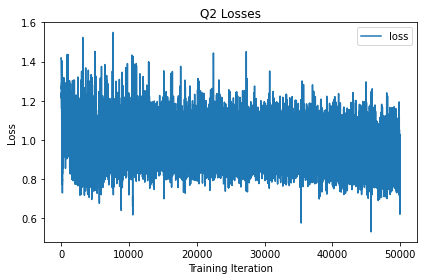

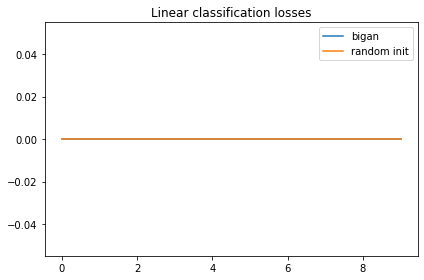

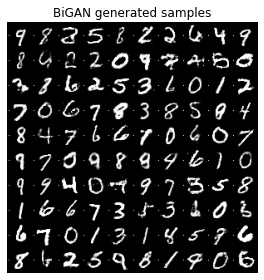

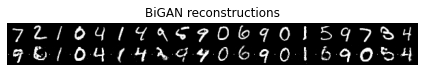

BiGAN final linear classification loss: 0.0
Random encoder linear classification loss: 0.0


In [69]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

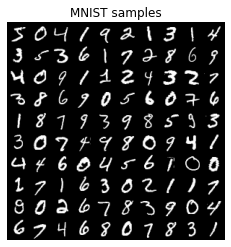

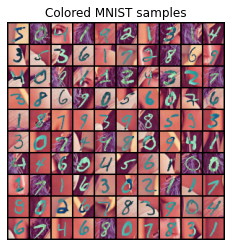

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

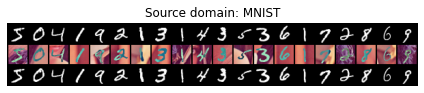

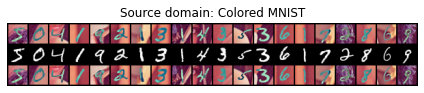

In [ ]:
b5_save_results(b5)